In [ ]:
import psycopg2
import csv
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import squareform, pdist
import pandas as pd
from psycopg2.extras import RealDictCursor
from scipy.stats import pearsonr

In [2]:
conn = psycopg2.connect(
    host="localhost",
    port=5432,
    dbname="test",
    user="siyuanzhao",
    cursor_factory=RealDictCursor
)
chromosome_name = 'chr1'
cell_line = 'K'
sequences = {"start": 770000, "end": 2705000}

In [ ]:
hic_file = "hic_data.csv"
position_file = "position.csv"
distance_file = "distance.csv"

cur = conn.cursor()
with open(hic_file, mode='r', encoding='utf-8') as f:
    reader = csv.DictReader(f)
    for row in reader:
        hid = row["hid"]
        chrid = row["chrid"]
        ibp = row["ibp"]
        jbp = row["jbp"]
        fq = row["fq"]
        fdr = row["fdr"]
        rawc = row["rawc"]
        cell_line = row["cell_line"]
        
        insert_query = """
            INSERT INTO non_random_hic (hid, chrid, ibp, jbp, fq, fdr, rawc, cell_line)
            VALUES (%s, %s, %s, %s, %s, %s, %s, %s)
        """

        cur.execute(insert_query, (hid, chrid, ibp, jbp, fq, fdr, rawc, cell_line))

conn.commit()

# with open(position_file, mode='r', encoding='utf-8') as f:
#     reader = csv.DictReader(f)
#     for row in reader:
#         pid = row["pid"]
#         cell_line = row["cell_line"]
#         chrid = row["chrid"]
#         sampleid = row["sampleid"]
#         start_value = row["start_value"]
#         end_value = row["end_value"]
#         x = row["x"]
#         y = row["y"]
#         z = row["z"]
#         insert_time = row["insert_time"]
        
#         insert_query = """
#             INSERT INTO position (pid, cell_line, chrid, sampleid, start_value, end_value, x, y, z, insert_time)
#             VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s)
#         """

#         cur.execute(insert_query, (pid, cell_line, chrid, sampleid, start_value, end_value, x, y, z, insert_time))

# conn.commit()

# with open(distance_file, mode='r', encoding='utf-8') as f:
#     reader = csv.DictReader(f)
#     for row in reader:
#         did = row["did"]
#         cell_line = row["cell_line"]
#         chrid = row["chrid"]
#         sampleid = row["sampleid"]
#         start_value = row["start_value"]
#         end_value = row["end_value"]
#         n_beads = row["n_beads"]
#         distance_vector = row["distance_vector"]
#         insert_time = row["insert_time"]
        
#         insert_query = """
#             INSERT INTO distance (did, cell_line, chrid, sampleid, start_value, end_value, n_beads, distance_vector, insert_time)
#             VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s)
#         """

#         cur.execute(insert_query, (did, cell_line, chrid, sampleid, start_value, end_value, n_beads, distance_vector, insert_time))

# conn.commit()
cur.close()
conn.close()

In [ ]:
def get_position_data(conn, chromosome_name, cell_line, sequences):
    cur = conn.cursor()
    cur.execute(
        """
        SELECT *
        FROM position
        WHERE chrid = %s
        AND cell_line = %s
        AND start_value = %s
        AND end_value = %s
        ORDER BY sampleid, pid
    """,
        (chromosome_name, cell_line, sequences["start"], sequences["end"]),
    )
    data = cur.fetchall()
    cur.close()
    return data

def get_distance_data(conn, chromosome_name, cell_line, sequences):
    cur = conn.cursor()
    cur.execute(
        """
        SELECT sampleid, distance_vector, n_beads
        FROM distance
        WHERE cell_line = %s
        AND chrid = %s
        AND start_value = %s
        AND end_value = %s
        ORDER BY sampleid
    """,
        (cell_line, chromosome_name, sequences["start"], sequences["end"]),
    )
    rows = cur.fetchall()
    cur.close()

    distance_data = []
    for row in rows:
        sample_data = {
            "sampleid": row["sampleid"],
            "distance_vector": row["distance_vector"],
            "n_beads": row["n_beads"]
        }
        distance_data.append(sample_data)
    
    return distance_data

def get_avg_distance_data(conn, chromosome_name, cell_line, sequences):
    cur = conn.cursor()
    cur.execute(
        """
        SELECT distance_vector
        FROM distance
        WHERE cell_line = %s
        AND chrid = %s
        AND start_value = %s
        AND end_value = %s
    """,
        (cell_line, chromosome_name, sequences["start"], sequences["end"]),
    )

    rows = cur.fetchall()
    cur.close()
    if not rows:
        return []

    # Convert all vectors at once for efficiency
    vectors = np.array([np.array(row["distance_vector"], dtype=float) for row in rows])
    avg_vector = np.mean(vectors, axis=0)
    
    # Convert the upper triangular distance vector to a full matrix
    avg_distance_matrix = squareform(avg_vector).tolist()
    
    return avg_distance_matrix

In [ ]:
def get_best_chain_sample():
    avg_distance_matrix = get_avg_distance_data(conn, chromosome_name, cell_line, sequences)
    avg_distance_vector = np.array(avg_distance_matrix).flatten()

    best_corr = None
    best_sample_id = None

    for sample_id in range(5000):
        sample_distance_matrix = get_distance_vector_by_sample(conn, chromosome_name, cell_line, sample_id, sequences)
        sample_distance_vector = np.array(sample_distance_matrix).flatten()
        
        corr, _ = pearsonr(sample_distance_vector, avg_distance_vector)
        print(corr, sample_id, 'corr_value')
        
        if best_corr is None or abs(1 - abs(corr)) < abs(1 - abs(best_corr)):
            best_corr = corr
            best_sample_id = sample_id

    print(best_corr, 'best_corr')
    return best_sample_id if best_corr is not None else None

def get_distance_vector_by_sample(conn, chromosome_name, cell_line, sampleid, sequences):
    cur = conn.cursor()
    query = """
        SELECT distance_vector
        FROM distance
        WHERE cell_line = %s
            AND sampleid = %s
            AND chrid = %s
            AND start_value = %s
            AND end_value = %s
        LIMIT 1;
    """
    cur.execute(query, (cell_line, sampleid, chromosome_name, sequences["start"], sequences["end"]))
    row = cur.fetchone()
    cur.close()

    full_distance_matrix = squareform(row["distance_vector"])
    avg_distance_matrix = full_distance_matrix.tolist()
    
    return avg_distance_matrix

def get_hic_data(conn, chromosome_name, cell_line, sequences):
    cur = conn.cursor()
    query = """
        SELECT *
        FROM non_random_hic
        WHERE cell_line = %s
            AND chrid = %s
            AND ibp >= %s
            AND ibp <= %s
            AND jbp >= %s
            AND jbp <= %s
            AND ibp < jbp
    """
    cur.execute(query, (cell_line, chromosome_name, sequences["start"], sequences["end"], sequences["start"], sequences["end"]))
    rows = cur.fetchall()
    cur.close()

    start, end = sequences["start"], sequences["end"]
    size = (end - start) // 5000
    if (end - start) % 5000 != 0:
        size += 1  

    matrix_dict = {}
    for row in rows:
        ibp, jbp, fq = row["ibp"], row["jbp"], row["fq"]
        if (ibp % 5000 == 0) and (jbp % 5000 == 0):
            i = (ibp - start) // 5000
            j = (jbp - start) // 5000
            if i < j:
                matrix_dict[(i, j)] = fq

    upper_triangle = []
    for i in range(size):
        for j in range(i+1, size):
            upper_triangle.append(matrix_dict.get((i, j), 0.0))
    
    return np.array(upper_triangle)

# for testing
def get_hic_data_matrix(conn, chromosome_name, cell_line, sequences):
    cur = conn.cursor()
    query = """
        SELECT *
        FROM non_random_hic
        WHERE cell_line = %s
            AND chrid = %s
            AND ibp >= %s
            AND ibp <= %s
            AND jbp >= %s
            AND jbp <= %s
            AND ibp < jbp
    """
    cur.execute(query, (cell_line, chromosome_name, sequences["start"], sequences["end"], sequences["start"], sequences["end"]))
    rows = cur.fetchall()
    cur.close()

    start, end = sequences["start"], sequences["end"]
    size = (end - start) // 5000
    if (end - start) % 5000 != 0:
        size += 1  
    print(size)
    matrix = np.zeros((size, size))

    for row in rows:
        ibp, jbp, fq = row["ibp"], row["jbp"], row["fq"]
        if (ibp % 5000 == 0) and (jbp % 5000 == 0):
            i = (ibp - start) // 5000
            j = (jbp - start) // 5000
            matrix[i, j] = fq

    matrix += matrix.T
    return matrix

In [ ]:
best_sample = get_best_chain_sample()
sample_id = best_sample
print(f"Best sample found: {sample_id}")
sample_distance_vector = get_distance_vector_by_sample(conn, chromosome_name, cell_line, sample_id, sequences)

0.8686432075411948 0 corr_value
0.8716790989205989 1 corr_value
0.8669683459648976 2 corr_value
0.8554119253077992 3 corr_value
0.8707930529997218 4 corr_value
0.853823994671622 5 corr_value
0.848995600474583 6 corr_value
0.8525590977992028 7 corr_value
0.8554691315865458 8 corr_value
0.8417033873106972 9 corr_value
0.8850581700815762 10 corr_value
0.8679631799835317 11 corr_value
0.8632884209922222 12 corr_value
0.8703173316248445 13 corr_value
0.8503129983208794 14 corr_value
0.8507136920967153 15 corr_value
0.8665949079305882 16 corr_value
0.878789177431913 17 corr_value
0.884898708363968 18 corr_value
0.8673636240417786 19 corr_value
0.8553922351711781 20 corr_value
0.8538878135824022 21 corr_value
0.878201133720129 22 corr_value
0.8706166991894577 23 corr_value
0.8668926873084947 24 corr_value
0.8670140489669519 25 corr_value
0.8414456839633201 26 corr_value
0.8486179126910444 27 corr_value
0.8850586167144041 28 corr_value
0.8574307794294163 29 corr_value
0.8681993816576253 30 cor

387


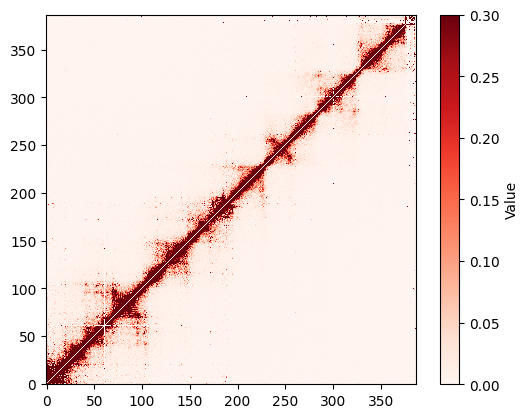

In [16]:
# original matrix(fq)
original = get_hic_data_matrix(conn, chromosome_name, cell_line, sequences)
plt.imshow(original, cmap='Reds', interpolation='nearest', origin='lower', vmin=0, vmax=0.3)
plt.colorbar(label="Value")
plt.show()

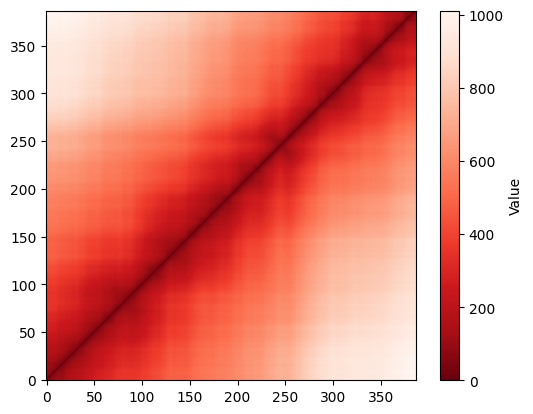

In [7]:
avg_distance_data = get_avg_distance_data(conn, chromosome_name, cell_line, sequences)
plt.imshow(avg_distance_data, cmap='Reds_r', interpolation='nearest', origin='lower')
plt.colorbar(label="Value")
plt.show()

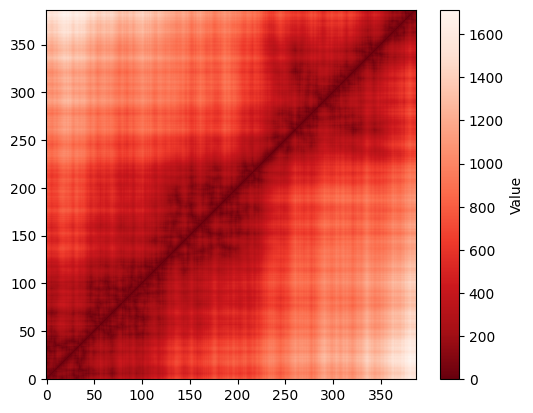

In [ ]:
# distance correlation
min_val = np.min(sample_distance_vector)
max_val = np.max(sample_distance_vector)
plt.imshow(sample_distance_vector, cmap='Reds_r', interpolation='nearest', origin='lower', vmin=min_val, vmax=0.1*max_val)
plt.colorbar(label="Value")
plt.show()